In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier

sns.set_theme(style="darkgrid")

In [2]:
df = pd.read_csv("../data/coffee_cleaned.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,date,datetime,cash_type,card,money,coffee_name,time_30min,time_of_day,hour_float_30min,day_of_week,weather
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024-03-01 10:30:00,10:30:00,10.5,4,sol
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03-01 12:30:00,12:30:00,12.5,4,sol
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024-03-01 12:30:00,12:30:00,12.5,4,sol
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024-03-01 14:00:00,14:00:00,14.0,4,sol
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024-03-01 14:00:00,14:00:00,14.0,4,sol


In [3]:
df["month"] = df["datetime"].dt.month
df["hour_sin"] = np.sin(2 * np.pi * df["hour_float_30min"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour_float_30min" ] / 24)
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

df["is_morning"] = (df["hour_float_30min"].between(6, 11)).astype(int)
df["is_afternoon"] = (df["hour_float_30min"].between(12, 17)).astype(int)
df["is_evening" ] = (df["hour_float_30min"] >= 18).astype(int)

In [4]:
df["morning_cold"] = ((df["is_morning"] == 1) & (df["weather"] == "frio")).astype(int)
df["evening_cold"] = ((df["is_evening"] == 1) & (df["weather"] == "frio")).astype(int)
df["weekend_morning"] = (df["is_weekend"] * df["is_morning"]).astype(int)

In [5]:
category_map = {
    "Americano": "Cafe Preto", "Espresso": "Cafe Preto", "Cortado": "Cafe Preto",
    "Latte": "Leite e Doces", "Americano with Milk": "Leite e Doces", 
    "Cappuccino": "Leite e Doces", "Cocoa": "Leite e Doces", "Hot Chocolate": "Leite e Doces"
}
df["coffee_category"] = df["coffee_name"].map(category_map)

In [6]:
features = [
    "hour_float_30min", "hour_sin", "hour_cos", "day_of_week", "month", 
    "weather", "cash_type", "is_weekend", "is_morning", "is_afternoon", 
    "is_evening", "morning_cold", "evening_cold", "weekend_morning"
]

X = df[features].copy()
le = LabelEncoder()
y = le.fit_transform(df["coffee_category"])
classes = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
train_data = pd.concat([X_train, pd.Series(y_train, name="target", index=X_train.index)], axis=1)
df_maj = train_data[train_data.target == 1]
df_min = train_data[train_data.target == 0]

df_min_up = resample(df_min, replace=True, n_samples=int(len(df_maj) * 0.67), random_state=42)
df_bal = pd.concat([df_maj, df_min_up])

X_train_bal = df_bal.drop("target", axis=1)
y_train_bal = df_bal["target"]

In [8]:
num_features = ["hour_float_30min", "hour_sin", "hour_cos", "month"]
cat_features = [f for f in features if f not in num_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
])

clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(random_state=42, n_jobs=-1))
])

In [9]:
param_dist = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__min_child_weight": [3, 5, 7],
    "model__gamma": [0.1, 0.2],
    "model__subsample": [0.7, 0.8],
    "model__colsample_bytree": [0.7, 0.8]
}

rs = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=15, 
    cv=5, scoring="balanced_accuracy", n_jobs=-1, random_state=42
)

rs.fit(X_train_bal, y_train_bal)
best_model = rs.best_estimator_

               precision    recall  f1-score   support

   Cafe Preto       0.43      0.43      0.43       201
Leite e Doces       0.78      0.78      0.78       527

     accuracy                           0.68       728
    macro avg       0.60      0.60      0.60       728
 weighted avg       0.68      0.68      0.68       728



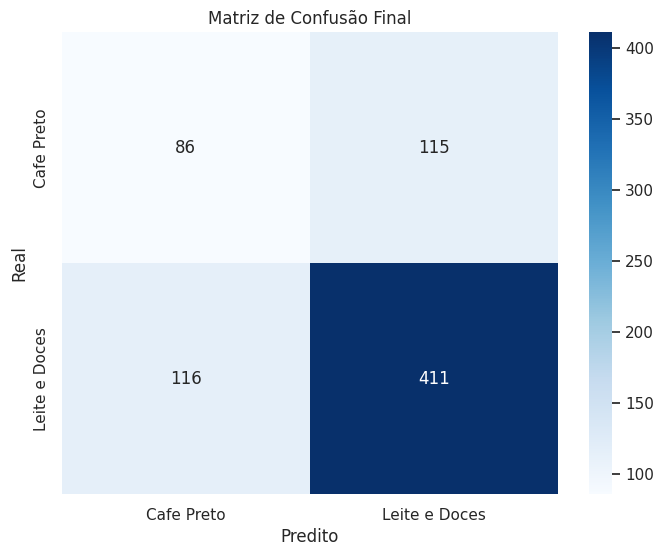

In [10]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=classes))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.title("Matriz de Confusão Final")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

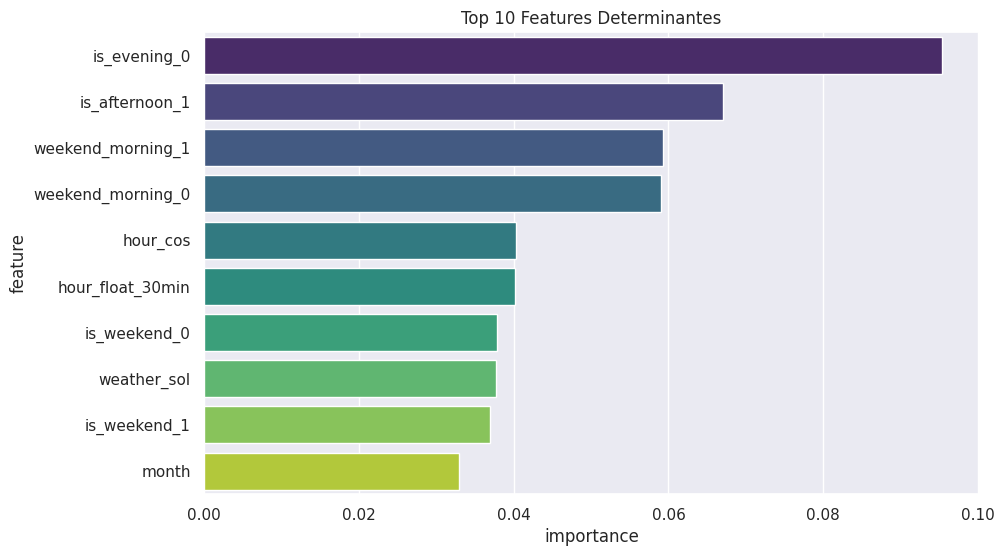

In [11]:
cat_cols = best_model.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(cat_features)
all_cols = num_features + list(cat_cols)

feat_imp = pd.DataFrame({
    "feature": all_cols,
    "importance": best_model.named_steps["model"].feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature", hue="feature", palette="viridis")
plt.title("Top 10 Features Determinantes")
plt.show()

In [14]:
df.to_csv('../data/model_trained_coffee.csv', index=False)